Desarollo de Modelo para Aprendizaje Profundo

In [1]:
# Importacion de librerias

# train_deep_traffic.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

Clases codificadas: ['game' 'instant-message' 'mail' 'network-storage' 'video' 'web-browsing']


d:\Proyectos\DProyecto\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
466/466 - 7s - 14ms/step - accuracy: 0.2777 - loss: 1.7029 - val_accuracy: 0.3076 - val_loss: 1.6486
Epoch 2/150
466/466 - 1s - 2ms/step - accuracy: 0.3183 - loss: 1.6527 - val_accuracy: 0.3435 - val_loss: 1.6178
Epoch 3/150
466/466 - 1s - 2ms/step - accuracy: 0.3322 - loss: 1.6209 - val_accuracy: 0.3503 - val_loss: 1.5961
Epoch 4/150
466/466 - 1s - 2ms/step - accuracy: 0.3449 - loss: 1.6058 - val_accuracy: 0.3481 - val_loss: 1.5829
Epoch 5/150
466/466 - 1s - 2ms/step - accuracy: 0.3474 - loss: 1.5954 - val_accuracy: 0.3553 - val_loss: 1.5733
Epoch 6/150
466/466 - 1s - 2ms/step - accuracy: 0.3506 - loss: 1.5870 - val_accuracy: 0.3572 - val_loss: 1.5632
Epoch 7/150
466/466 - 1s - 2ms/step - accuracy: 0.3512 - loss: 1.5810 - val_accuracy: 0.3592 - val_loss: 1.5592
Epoch 8/150
466/466 - 1s - 2ms/step - accuracy: 0.3595 - loss: 1.5720 - val_accuracy: 0.3662 - val_loss: 1.5518
Epoch 9/150
466/466 - 1s - 2ms/step - accuracy: 0.3595 - loss: 1.5655 - val_accuracy: 0.3670 - val_loss

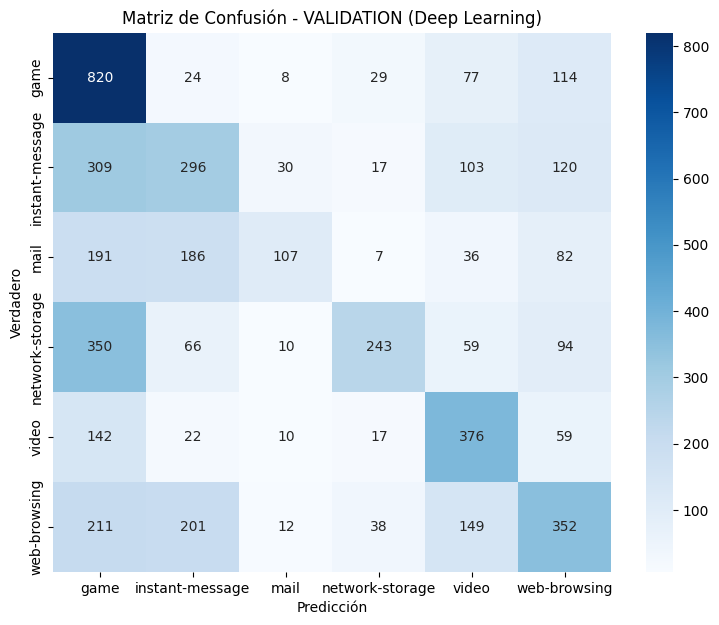


Scores finales en VALIDATION:
Accuracy: 0.442
F1-score (macro): 0.415
F1-score (weighted): 0.422


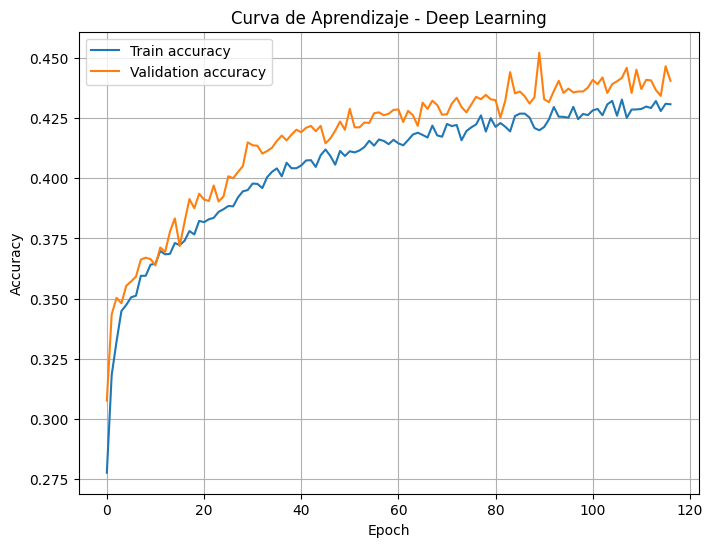

In [ ]:
# ==============================
# Cargar dataset
# ==============================
df = pd.read_csv("Dataset/dataset_all1.csv")  
# Carga el dataset desde un CSV. df es un DataFrame con todas las columnas y filas.

# ==============================
# Preparar features y etiquetas
# ==============================
X = df.drop(columns=['flow_id','class'])  # Features del modelo, eliminando columnas no útiles
y = df['class']                            # Etiqueta objetivo (clase a predecir)

# ==============================
# Codificar etiquetas
# ==============================
le = LabelEncoder()
y_encoded = le.fit_transform(y)            # Convierte etiquetas de texto a números (0,1,2,...)
num_classes = len(le.classes_)             # Número de clases únicas
print("Clases codificadas:", le.classes_)  # Muestra las clases originales

# ==============================
# Escalar features
# ==============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)         # Normaliza las features (media 0, desviación 1)

# ==============================
# División Train/Test/Validation
# ==============================
# Primer split: 80% entrenamiento completo, 20% validación
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
# Segundo split: 75% de entrenamiento completo para train, 25% para test
X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)
# Resultado: 60% train, 20% test, 20% validation

# ==============================
# Convertir etiquetas a one-hot
# ==============================
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)  # One-hot para entrenamiento
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)      # One-hot para validación

# ==============================
# Construir modelo deep learning
# ==============================
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Capa densa 128 neuronas
    Dropout(0.3),                                                    # Regularización para evitar overfitting
    Dense(64, activation='relu'),                                     # Segunda capa densa 64 neuronas
    Dropout(0.2),                                                     # Regularización
    Dense(num_classes, activation='softmax')                          # Capa de salida con softmax
])

model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)  # Compila el modelo con Adam, pérdida categórica y métrica accuracy

# Early stopping para detener entrenamiento si no mejora validación
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ==============================
# Entrenamiento
# ==============================
history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)
# Entrena el modelo hasta 150 epochs o hasta que la validación no mejore por 10 epochs

# ==============================
# Evaluación en VALIDATION
# ==============================
y_val_pred_prob = model.predict(X_val)                  # Probabilidades de predicción
y_val_pred = np.argmax(y_val_pred_prob, axis=1)         # Clase con mayor probabilidad

print("\n=== Reporte de clasificación en VALIDATION ===")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))
# Muestra precision, recall y f1-score por clase

# Matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - VALIDATION (Deep Learning)")
plt.show()

# ==============================
# Scores finales
# ==============================
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val_macro = f1_score(y_val, y_val_pred, average='macro')
f1_val_weighted = f1_score(y_val, y_val_pred, average='weighted')

print("\nScores finales en VALIDATION:")
print(f"Accuracy: {accuracy_val:.3f}")
print(f"F1-score (macro): {f1_val_macro:.3f}")
print(f"F1-score (weighted): {f1_val_weighted:.3f}")
# Muestra métricas globales del modelo

# ==============================
# Curva de aprendizaje
# ==============================
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title("Curva de Aprendizaje - Deep Learning")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
# Grafica la evolución del accuracy en entrenamiento y validación


Clases codificadas: ['game' 'instant-message' 'mail' 'network-storage' 'video' 'web-browsing']
Epoch 1/150


d:\Proyectos\DProyecto\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 - 2s - 22ms/step - accuracy: 0.4567 - loss: 1.3930 - val_accuracy: 0.5649 - val_loss: 1.1285
Epoch 2/150
72/72 - 0s - 3ms/step - accuracy: 0.5245 - loss: 1.1635 - val_accuracy: 0.5872 - val_loss: 1.0641
Epoch 3/150
72/72 - 0s - 3ms/step - accuracy: 0.5485 - loss: 1.1246 - val_accuracy: 0.5609 - val_loss: 1.0534
Epoch 4/150
72/72 - 0s - 3ms/step - accuracy: 0.5459 - loss: 1.1174 - val_accuracy: 0.5885 - val_loss: 1.0383
Epoch 5/150
72/72 - 0s - 3ms/step - accuracy: 0.5476 - loss: 1.0985 - val_accuracy: 0.5911 - val_loss: 1.0393
Epoch 6/150
72/72 - 0s - 3ms/step - accuracy: 0.5503 - loss: 1.0983 - val_accuracy: 0.5898 - val_loss: 1.0254
Epoch 7/150
72/72 - 0s - 3ms/step - accuracy: 0.5695 - loss: 1.0801 - val_accuracy: 0.5858 - val_loss: 1.0240
Epoch 8/150
72/72 - 0s - 3ms/step - accuracy: 0.5673 - loss: 1.0635 - val_accuracy: 0.5937 - val_loss: 1.0193
Epoch 9/150
72/72 - 0s - 3ms/step - accuracy: 0.5830 - loss: 1.0532 - val_accuracy: 0.5819 - val_loss: 1.0193
Epoch 10/150
72/72 - 

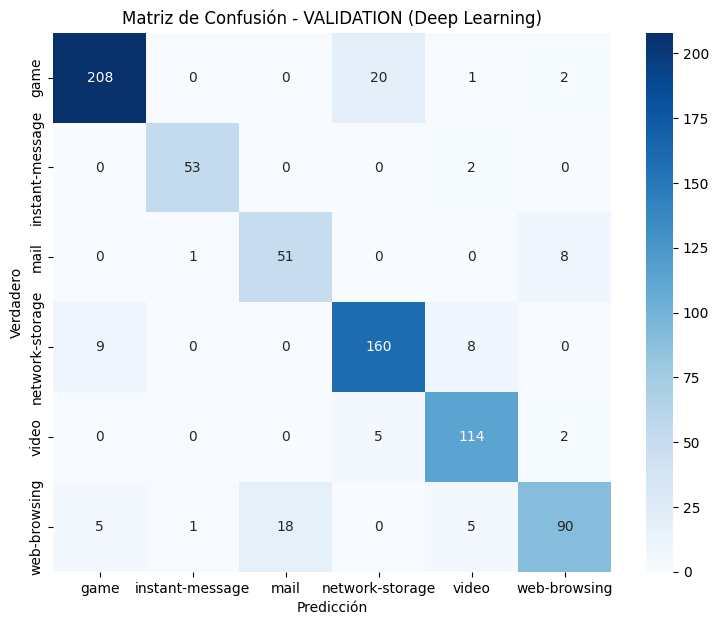


Scores finales en VALIDATION:
Accuracy: 0.886
F1-score (macro): 0.880
F1-score (weighted): 0.886


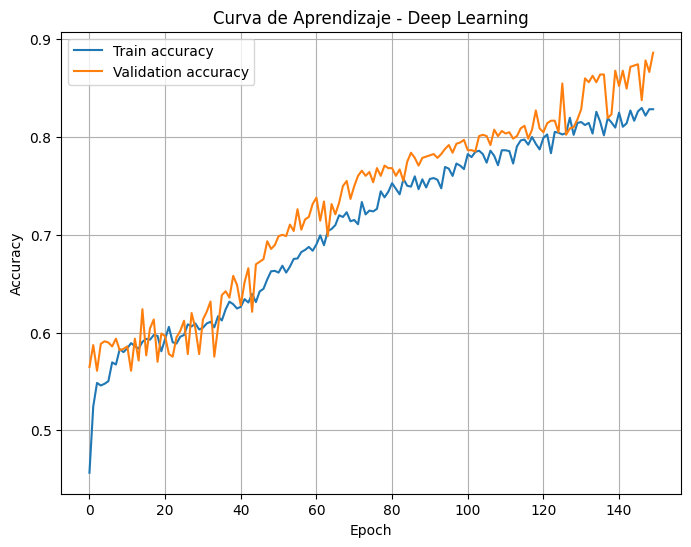

In [4]:
#Entrenamiento con Dataset window

# ==============================
# Cargar dataset
# ==============================
df = pd.read_csv("Dataset/dataset_all2.csv")  
# Carga el dataset desde un CSV. df es un DataFrame con todas las columnas y filas.

# ==============================
# Preparar features y etiquetas
# ==============================
X = df.drop(columns=['class'])  # Features del modelo, eliminando columnas no útiles
y = df['class']                            # Etiqueta objetivo (clase a predecir)

# ==============================
# Codificar etiquetas
# ==============================
le = LabelEncoder()
y_encoded = le.fit_transform(y)            # Convierte etiquetas de texto a números (0,1,2,...)
num_classes = len(le.classes_)             # Número de clases únicas
print("Clases codificadas:", le.classes_)  # Muestra las clases originales

# ==============================
# Escalar features
# ==============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)         # Normaliza las features (media 0, desviación 1)

# ==============================
# División Train/Test/Validation
# ==============================
# Primer split: 80% entrenamiento completo, 20% validación
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
# Segundo split: 75% de entrenamiento completo para train, 25% para test
X_train, X_test, y_train, y_test = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
)
# Resultado: 60% train, 20% test, 20% validation

# ==============================
# Convertir etiquetas a one-hot
# ==============================
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)  # One-hot para entrenamiento
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)      # One-hot para validación

# ==============================
# Construir modelo deep learning
# ==============================
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Capa densa 128 neuronas
    Dropout(0.3),                                                    # Regularización para evitar overfitting
    Dense(64, activation='relu'),                                     # Segunda capa densa 64 neuronas
    Dropout(0.2),                                                     # Regularización
    Dense(num_classes, activation='softmax')                          # Capa de salida con softmax
])

model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)  # Compila el modelo con Adam, pérdida categórica y métrica accuracy

# Early stopping para detener entrenamiento si no mejora validación
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ==============================
# Entrenamiento
# ==============================
history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)
# Entrena el modelo hasta 150 epochs o hasta que la validación no mejore por 10 epochs

# ==============================
# Evaluación en VALIDATION
# ==============================
y_val_pred_prob = model.predict(X_val)                  # Probabilidades de predicción
y_val_pred = np.argmax(y_val_pred_prob, axis=1)         # Clase con mayor probabilidad

print("\n=== Reporte de clasificación en VALIDATION ===")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))
# Muestra precision, recall y f1-score por clase

# Matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión - VALIDATION (Deep Learning)")
plt.show()

# ==============================
# Scores finales
# ==============================
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_val_macro = f1_score(y_val, y_val_pred, average='macro')
f1_val_weighted = f1_score(y_val, y_val_pred, average='weighted')

print("\nScores finales en VALIDATION:")
print(f"Accuracy: {accuracy_val:.3f}")
print(f"F1-score (macro): {f1_val_macro:.3f}")
print(f"F1-score (weighted): {f1_val_weighted:.3f}")
# Muestra métricas globales del modelo

# ==============================
# Curva de aprendizaje
# ==============================
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title("Curva de Aprendizaje - Deep Learning")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
# Grafica la evolución del accuracy en entrenamiento y validación
